# Produce training and test dataset from cleaned data

Change log
- In loop for clean_goals table, end index changed to 18 (instead of 17)  
    `for ix in range(2,18)`
- Result saved in new table: `Training_set_new`

In [1]:
import sqlite3
import numpy as np

In [2]:
def fetchTrainingData(db, sqlCmd):
    try:
        conn = sqlite3.connect(db)
        cursor = conn.cursor()
        cursor.execute(sqlCmd)
        result = cursor.fetchall()
        conn.commit()
        cursor.close()
        return result

    except sqlite3.Error as error:
        print("Failed to run sqlite command", error)
    finally:
        if (conn):
            conn.close()

In [3]:
db_path = 'db/categorised_swecris.sqlite'

In [4]:
init = False
for ix in range(2,18):
    sqlCmd = f'''
        SELECT abstract, Formas1 AS class FROM clean_swecris
            WHERE class == '{ix}' ORDER BY RANDOM() LIMIT 99
        '''
    result = np.array(fetchTrainingData(db_path, sqlCmd))
    if (not init and result.size > 0):
        training_data_Formas = np.copy(result)
        init = True
    elif (result.size > 0):
        training_data_Formas = np.vstack((training_data_Formas, result))

In [5]:
init = False
for ix in range(2,18):
    sqlCmd = f'''
        SELECT abstract, Self1 AS class FROM clean_swecris 
            WHERE Self1 == '{ix}' ORDER BY RANDOM()
            LIMIT
                CASE 
                    WHEN (99 - (SELECT count(Formas1) FROM clean_swecris WHERE Formas1 == '{ix}')) > 0
                        THEN (SELECT 99 - count(Formas1) FROM clean_swecris WHERE Formas1 == '{ix}')
                    ELSE 0
                END;
        '''
    result = np.array(fetchTrainingData(db_path, sqlCmd))
    if (not init and result.size > 0):
        training_data_Vinnova = np.copy(result)
        init = True
    elif (result.size > 0):
        training_data_Vinnova = np.vstack((training_data_Vinnova, result))

In [6]:
init = False
for ix in range(2,18):
    sqlCmd = f'''
        SELECT abstract, goals AS class FROM clean_goals
            WHERE class == '{ix}';
        '''
    result = np.array(fetchTrainingData(db_path, sqlCmd))
    if (not init and result.size > 0):
        training_data_Goals = np.copy(result)
        init = True
    else:
        training_data_Goals = np.vstack((training_data_Goals, result))

In [8]:
# training_data_Goals

In [9]:
training_data = np.vstack((training_data_Goals, training_data_Formas, training_data_Vinnova))

In [10]:
import pandas as pd

In [11]:
training_data_df = pd.DataFrame(data=training_data[:,:], columns=['abstract', 'class'])

In [12]:
training_data_df.head()

,abstract,class
0,ingen hung hung vara en främst dödsorsak i vär...,2
1,god hälsa och välbefinnande god hälsa vara en ...,3
2,god utbildning för alla utbildning vara en gru...,4
3,jämställdhet jämställdhet mellan kvinna och ma...,5
4,ren vatten och sanitet för alla vatten vara en...,6


In [13]:
training_data_df['len'] = training_data_df['abstract'].apply(lambda s : len(s))

<AxesSubplot:ylabel='Frequency'>

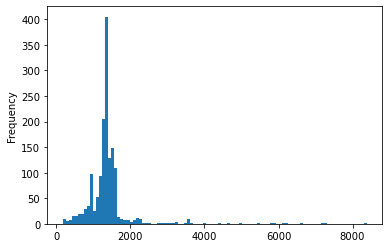

In [14]:
training_data_df['len'].plot.hist(bins=100)

In [15]:
training_data_df.len.quantile(0.9)

1605.0

In [16]:
from sqlalchemy import create_engine
table_name = 'Training_set_new'
db_path = 'db/training.sqlite'
db_path = 'sqlite:///' + db_path
engine = create_engine(db_path, echo=True)

In [17]:
training_data_df.to_sql(table_name, engine, if_exists='fail')

2020-12-19 16:52:45,029 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2020-12-19 16:52:45,030 INFO sqlalchemy.engine.base.Engine ()
2020-12-19 16:52:45,032 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2020-12-19 16:52:45,033 INFO sqlalchemy.engine.base.Engine ()
2020-12-19 16:52:45,035 INFO sqlalchemy.engine.base.Engine PRAGMA main.table_info("Training_set_new")
2020-12-19 16:52:45,036 INFO sqlalchemy.engine.base.Engine ()
2020-12-19 16:52:45,037 INFO sqlalchemy.engine.base.Engine PRAGMA temp.table_info("Training_set_new")
2020-12-19 16:52:45,038 INFO sqlalchemy.engine.base.Engine ()
2020-12-19 16:52:45,041 INFO sqlalchemy.engine.base.Engine 
CREATE TABLE "Training_set_new" (
	"index" BIGINT, 
	abstract TEXT, 
	class TEXT, 
	len BIGINT
)


2020-12-19 16:52:45,042 INFO sqlalchemy.engine.base.Engine ()
2020-12-19 16:52:45,054 INFO sqlalchemy.engine.base.Engine COMMIT
2020-12-19 16:52:45,055